## Bad thermometer.
This notebook showcase a classical example of applying AR models - temperature prediction.
Here we will take this problem one step further: first we assume our measurements be noisy, second we use pure online learning methodology, i.e. we approximate our posterior at each new observation and use the posterior distribution as a prior for the next timestep.
Furthermore, we select the best model (best AR order) based of FE score.


\begin{align}  &\mathbf{x}_t = A(\theta_{t})\mathbf{x}_{t-1} + \mathbf{c}b_t + \mathbf{c}v_{t} \\ &y_t = \mathbf{c}^{\top} \mathbf{x}_{t} + w_t \end{align} where 

In [130]:
include("helpers.jl")
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision, unsafeMeanCov
using LAR
using LAR.Node
using ProgressMeter
using LinearAlgebra
using LAR
using Plots
using Random

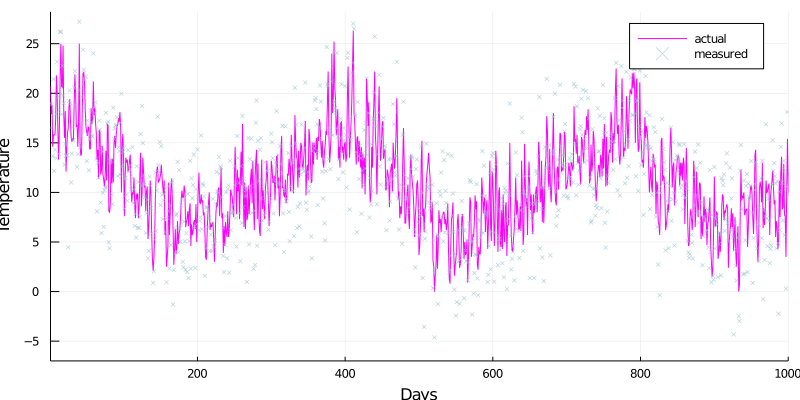

In [141]:
Random.seed!(42)

x = loadAR("data/weather/temperature.csv", col=2)
ξ_real = 10.0
y = x .+ sqrt(ξ_real) .* randn(length(x));
plot(x, label="actual", color=:magenta,  xlabel="Days", ylabel="Temperature")
scatter!(y, label="measured", markershape = :xcross, markeralpha = 0.6, markersize = 2, xlims=(1, 1000), color=:lightblue3, size=(800, 400))
#savefig("figures/daily_temperature.pdf")

In [142]:
function generate_algorithm(ARorder)
    graph = FactorGraph()
    # Coefficients
    @RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(ARorder,)), placeholder(:w_θ, dims=(ARorder, ARorder)))
    @RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
    @RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
    @RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))
    c = zeros(ARorder); c[1] = 1.0
    # State prior
    @RV x_t_prev ~ GaussianMeanPrecision(placeholder(:m_x_t_prev, dims=(ARorder,)), placeholder(:w_x_t_prev, dims=(ARorder, ARorder)))
    # Autoregressive node
    @RV x_t ~ Autoregressive(θ, x_t_prev, γ)
    # Add bias
    @RV z_t = x_t + η*c
    # Specify likelihood
    @RV y_t ~ GaussianMeanPrecision(dot(c, z_t), ξ)
    # Placeholders
    placeholder(y_t, :y_t)
    
    # Inference algorithm
    q = PosteriorFactorization([x_t, x_t_prev], θ, γ, ξ, ids=[:X :Θ :Γ :Ξ])
    algo = messagePassingAlgorithm(free_energy=true)
    source_code = algorithmSourceCode(algo, free_energy=true)
    
    return source_code
end


generate_algorithm (generic function with 1 method)

In [143]:
function run_inference(ARorder, ξ)
    T = length(y)
    # Inference parameters
    vmp_iter = 10

    # Initialize marginal distribution and observed data dictionaries
    data = Dict()
    marginals = Dict()
    predictions = Array{Message}(undef, T, vmp_iter)

    # Initialize arrays of parameterizations
    params_x = (zeros(ARorder,T+1), 0.01 * repeat(float(eye(ARorder)), outer=(1,1,T+1)))
    params_θ = (zeros(ARorder,T+1), repeat(float(eye(ARorder)), outer=(1,1,T+1)))
    params_η = (ones(1,T+1), ones(1,T+1))
    params_γ = (ones(1,T+1), ones(1,T+1))
    params_ξ = (inv(ξ)*ones(1,T+1), ones(1,T+1))

    # Initialize message array
    messages = Array{Message}(undef, 14)
    # Initialize free energy array
    FE = zeros(T, vmp_iter)
    # Perform inference at each time-step
    @showprogress "Filtering " for t in 1:T
        # Initialize marginals
        marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
        marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
        marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
        marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
        # Set clamped variables
        data = Dict(:y_t => y[t],
                    :m_η => params_η[1][1, t],
                    :w_η => params_η[2][1, t],
                    :m_x_t_prev => params_x[1][:,t],
                    :w_x_t_prev => params_x[2][:,:,t],
                    :m_θ => params_θ[1][:,t],
                    :w_θ => params_θ[2][:,:,t],
                    :a_γ => params_γ[1][1,t],
                    :b_γ => params_γ[2][1,t],
                    :a_ξ => params_ξ[1][1,t],
                    :b_ξ => params_ξ[2][1,t])

        # Iterate variational parameter updates
        for i in 1:vmp_iter
            # Update recognition factors
            stepX!(data, marginals, messages)
            stepΘ!(data, marginals)
            stepΓ!(data, marginals)
            # identifiability issues
            stepΞ!(data, marginals)
            # Update marginal for z_t manually
            marginals[:z_t] = messages[11].dist * messages[3].dist
            FE[t, i] = freeEnergy(data, marginals)
            predictions[t, i] = messages[11]
        end    

        # Store current parameterizations of marginals
        params_x[1][:,t+1] = unsafeMean(marginals[:z_t])
        params_x[2][:,:,t+1] = unsafePrecision(marginals[:z_t])
        params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
        params_θ[2][:,:,t+1] = unsafePrecision(marginals[:θ])
        params_γ[1][1,t+1] = marginals[:γ].params[:a]
        params_γ[2][1,t+1] = marginals[:γ].params[:b]
        params_η[1][1,t+1] = unsafeMean(marginals[:η])
        params_η[2][1,t+1] = unsafePrecision(marginals[:η])
        params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
        params_ξ[2][1,t+1] = marginals[:ξ].params[:b]
    end
    return params_x, params_θ, params_η, params_γ, params_ξ, predictions, FE
end

run_inference (generic function with 2 methods)

In [144]:
ARorder = 2
code = generate_algorithm(ARorder)
eval(Meta.parse(code));
params_x_1, params_θ_1, params_η_1, params_γ_1, params_ξ_1, predictions_1, FE_1 = run_inference(ARorder, ξ_real);

Filtering 100%|█████████████████████████████████████████| Time: 0:00:10


In [145]:
ARorder = 3
code = generate_algorithm(ARorder)
eval(Meta.parse(code));
params_x_2, params_θ_2, params_η_2, params_γ_2, params_ξ_2, predictions_2, FE_2 = run_inference(ARorder, ξ_real);

Filtering 100%|█████████████████████████████████████████| Time: 0:00:11


In [146]:
ARorder = 4
code = generate_algorithm(ARorder)
eval(Meta.parse(code));
params_x_3, params_θ_3, params_η_3, params_γ_3, params_ξ_3, predictions_3, FE_3 = run_inference(ARorder, ξ_real);

Filtering 100%|█████████████████████████████████████████| Time: 0:00:13


In [147]:
ARorder = 10
code = generate_algorithm(ARorder)
eval(Meta.parse(code));
params_x_4, params_θ_4, params_η_4, params_γ_4, params_ξ_4, predictions_4, FE_4 = run_inference(ARorder, ξ_real);

Filtering 100%|█████████████████████████████████████████| Time: 0:00:26


In [148]:
lims = (1, 300)

(1, 300)

In [149]:
using JLD
save("data/weather/weather.jld", "real", x, "observed", y, 
     "params_x_1", params_x_1, "params_θ_1", params_θ_1, "params_η_1", params_η_1, "params_γ_1", params_γ_1,
     "params_ξ_1", params_ξ_1, "predictions_1", predictions_1, "FE_1", FE_1,
     "params_x_2", params_x_2, "params_θ_2", params_θ_2, "params_η_2", params_η_2, "params_γ_2", params_γ_2,
     "params_ξ_2", params_ξ_2, "predictions_2", predictions_2, "FE_2", FE_2,
     "params_x_3", params_x_3, "params_θ_3", params_θ_3, "params_η_3", params_η_3, "params_γ_3", params_γ_3,
     "params_ξ_3", params_ξ_3, "predictions_3", predictions_3, "FE_3", FE_3,
     "params_x_4", params_x_4, "params_θ_4", params_θ_4, "params_η_4", params_η_4, "params_γ_4", params_γ_4,
     "params_ξ_4", params_ξ_4, "predictions_4", predictions_4, "FE_4", FE_4)

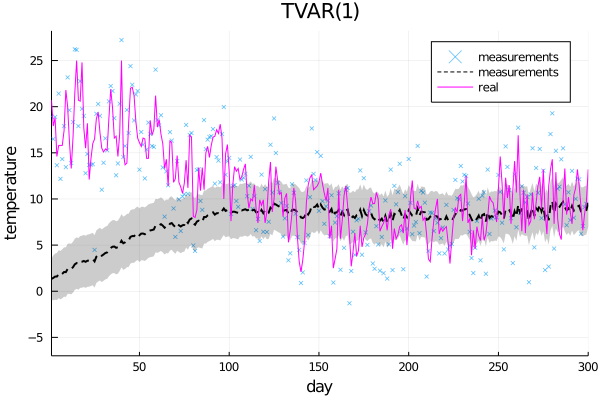

In [150]:
plot(xlims = lims, title="TVAR(1)")
scatter!(y, markershape = :xcross, markeralpha = 0.6, markersize = 2, label="measurements")
plot!(params_x_1[1][1, :][2:end], ribbon=sqrt.(inv.(params_x_1[2][1, 1, :][2:end])), linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black, label="measurements")
plot_ar1 = plot!(x, label="real", color="magenta",  xlabel="day", ylabel="temperature")

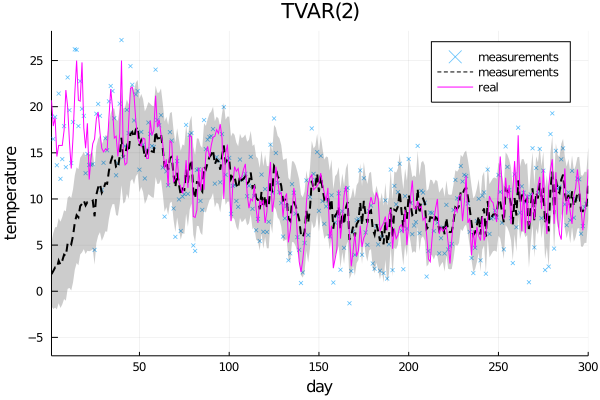

In [151]:
plot(xlims = lims, title="TVAR(2)")
scatter!(y, markershape = :xcross, markeralpha = 0.6, markersize = 2, label="measurements")
plot!(params_x_2[1][1, :][2:end], ribbon=sqrt.(inv.(params_x_2[2][1, 1, :][2:end])), linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black, label="measurements")
plot_ar2 = plot!(x, label="real", color="magenta",  xlabel="day", ylabel="temperature")

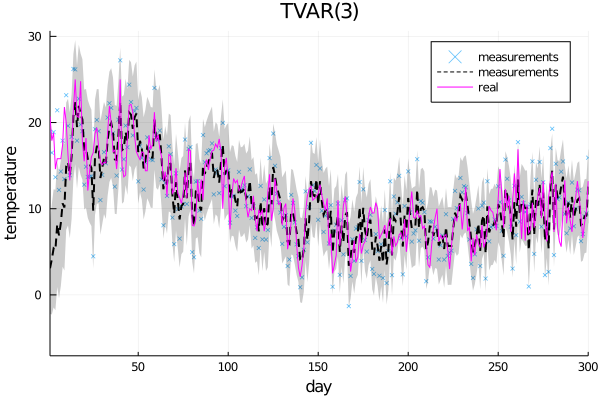

In [152]:
plot(xlims = lims, title="TVAR(3)")
scatter!(y, markershape = :xcross, markeralpha = 0.6, markersize = 2, label="measurements")
plot!(params_x_3[1][1, :][2:end], ribbon=sqrt.(inv.(params_x_3[2][1, 1, :][2:end])), linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black, label="measurements")
plot_ar3 = plot!(x, label="real", color="magenta",  xlabel="day", ylabel="temperature")

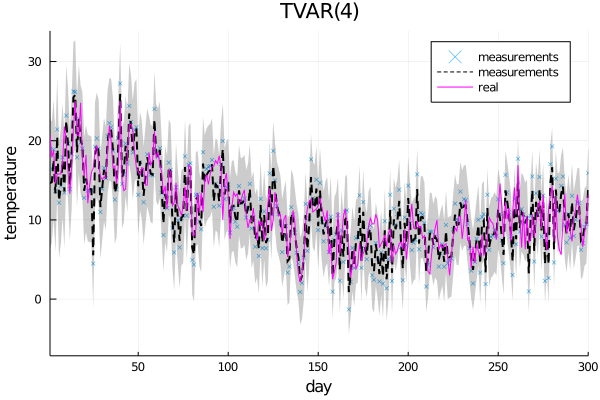

In [153]:
plot(xlims = lims, title="TVAR(4)")
scatter!(y, markershape = :xcross, markeralpha = 0.6, markersize = 2, label="measurements")
plot!(params_x_4[1][1, :][2:end], ribbon=sqrt.(inv.(params_x_4[2][1, 1, :][2:end])), linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black, label="measurements")
plot_ar4 = plot!(x, label="real", color="magenta",  xlabel="day", ylabel="temperature")

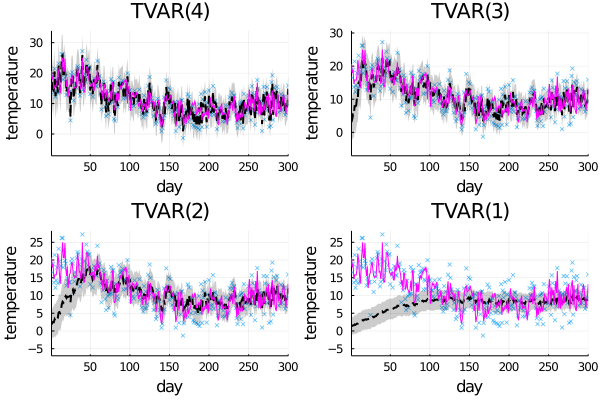

In [154]:
plot(plot_ar4, plot_ar3, plot_ar2, plot_ar1, legend=false)
#savefig("figures/weather_inference.pdf")

# Prediction under uncertainty

In [155]:
import ForneyLab: unsafeMean, unsafeCov
predictions = predictions_4[:, 1]
m_pred = [unsafeMean(prediction.dist)[1] for prediction in predictions]
v_pred = [unsafeCov(prediction.dist)[1] for prediction in predictions];

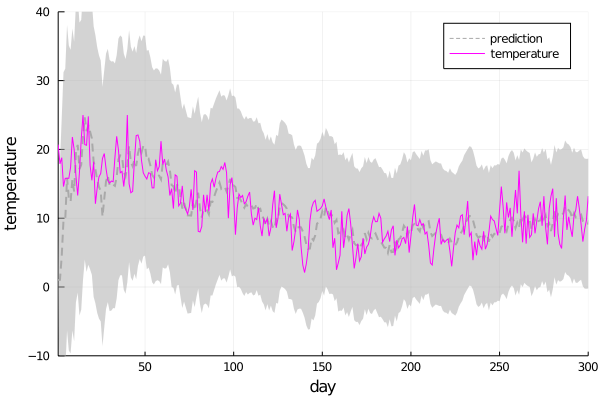

In [156]:
future_x = x[2:end]
plot(m_pred, ribbon=sqrt.(v_pred), xlims=lims, ylims=(-10, 40), linestyle=:dash, linewidth = 2, color=:darkgray, fillalpha = 0.5, fillcolor = :darkgray, label="prediction")
plot!(x, label="temperature", color="magenta",  xlabel="day", ylabel="temperature")
#savefig("figures/prediction_weather.svg")

In [53]:
fe_1 = sum(FE_1, dims=1) ./ length(y)
fe_2 = sum(FE_2, dims=1) ./ length(y)
fe_3 = sum(FE_3, dims=1) ./ length(y)
fe_4 = sum(FE_4, dims=1) ./ length(y)

1×10 Matrix{Float64}:
 2.49568  2.48899  2.48866  2.48847  …  2.48794  2.4879  2.48789  2.48789

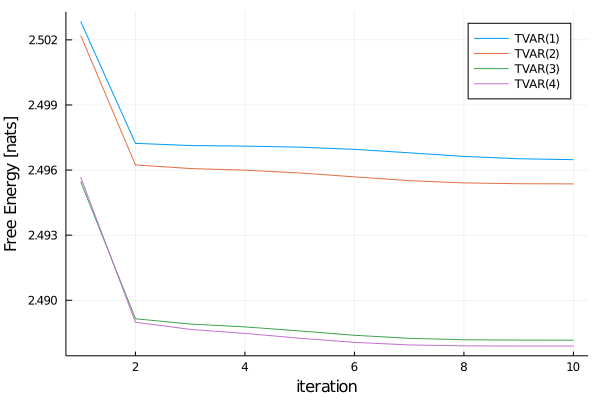

In [54]:
plot(fe_1', xlabel="iteration", ylabel="Free Energy [nats]", label="TVAR(1)")
plot!(fe_2', label="TVAR(2)")
plot!(fe_3', label="TVAR(3)")
plot!(fe_4', label="TVAR(4)")
#savefig("figures/weather_vmp_iterations.pdf")

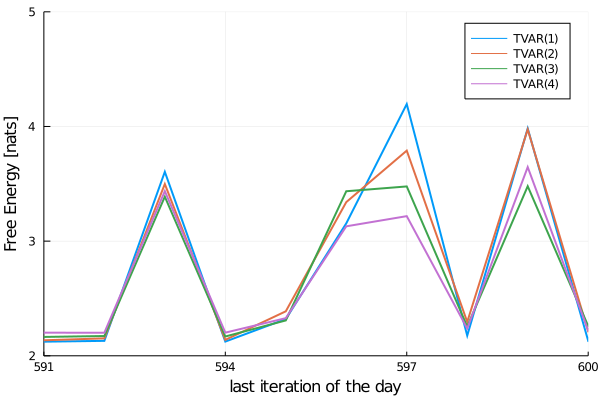

In [55]:
lims = (591, 600)
plot(FE_1[:, end], label="TVAR(1)", ylims=(2, 5), xlims=lims, ylabel="Free Energy [nats]", xlabel="last iteration of the day", linewidth=2.0)
plot!(FE_2[:, end], label="TVAR(2)", linewidth=2.0)
plot!(FE_3[:, end], label="TVAR(3)", linewidth=2.0)
plot!(FE_4[:, end], label="TVAR(4)", linewidth=2.0)
#savefig("figures/weather_vmp_time_frame.pdf")

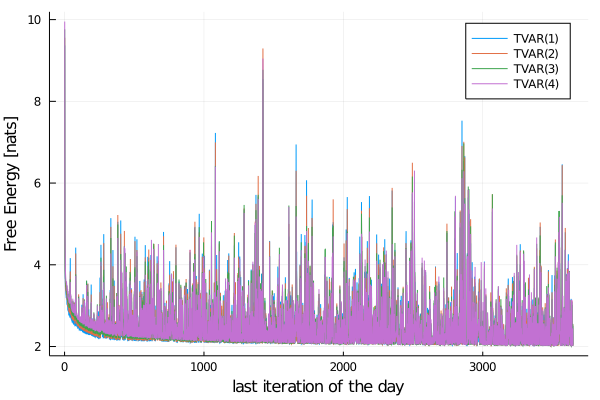

In [56]:
plot(FE_1[:, end], label="TVAR(1)", ylabel="Free Energy [nats]", xlabel="last iteration of the day")
plot!(FE_2[:, end], label="TVAR(2)", ylabel="Free Energy [nats]", xlabel="last iteration of the day")
plot!(FE_3[:, end], label="TVAR(3)", ylabel="Free Energy [nats]", xlabel="last iteration of the day")
plot!(FE_4[:, end], label="TVAR(4)", ylabel="Free Energy [nats]", xlabel="last iteration of the day")
#savefig("figures/weather_vmp_over_time.pdf")

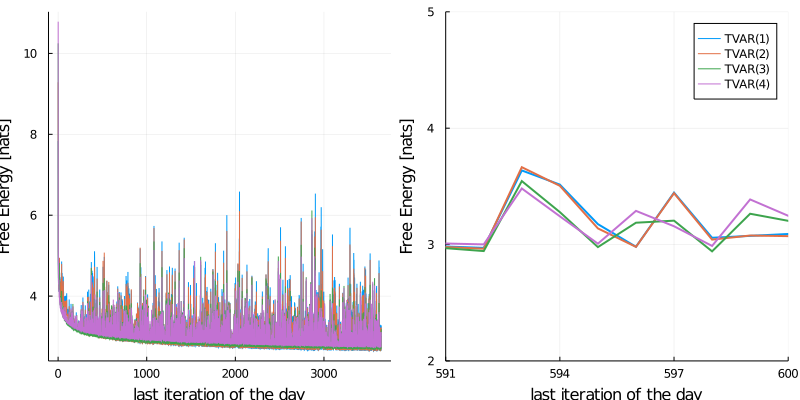

In [37]:
lims = (591, 600)
plot(FE_1[:, end], label="TVAR(1)", ylims=(2, 5), xlims=lims, ylabel="Free Energy [nats]", xlabel="last iteration of the day", linewidth=2.0)
plot!(FE_2[:, end], label="TVAR(2)", linewidth=2.0)
plot!(FE_3[:, end], label="TVAR(3)", linewidth=2.0)
frame = plot!(FE_4[:, end], label="TVAR(4)", linewidth=2.0)

plot(FE_1[:, end], label="TVAR(1)", ylabel="Free Energy [nats]", xlabel="last iteration of the day")
plot!(FE_2[:, end], label="TVAR(2)", ylabel="Free Energy [nats]", xlabel="last iteration of the day")
plot!(FE_3[:, end], label="TVAR(3)", ylabel="Free Energy [nats]", xlabel="last iteration of the day")
time = plot!(FE_4[:, end], label="TVAR(4)", ylabel="Free Energy [nats]", xlabel="last iteration of the day", legend=false)

plot(time, frame, size=(800, 400))
#savefig("figures/weather_vmp_time_frame.pdf")